<a href="https://colab.research.google.com/github/SatioO/DL_Practices/blob/master/PSPNET_with_tf2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from math import ceil
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
!unzip "/content/drive/My Drive/Launch pad/vocseg.zip"

Archive:  /content/drive/My Drive/Launch pad/vocseg.zip
replace tfrecord/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: tfrecord/.DS_Store      
  inflating: __MACOSX/tfrecord/._.DS_Store  
  inflating: tfrecord/train-00002-of-00004.tfrecord  
  inflating: __MACOSX/tfrecord/._train-00002-of-00004.tfrecord  
  inflating: tfrecord/val-00002-of-00004.tfrecord  
  inflating: __MACOSX/tfrecord/._val-00002-of-00004.tfrecord  
  inflating: tfrecord/train-00003-of-00004.tfrecord  
  inflating: __MACOSX/tfrecord/._train-00003-of-00004.tfrecord  
  inflating: tfrecord/val-00003-of-00004.tfrecord  
  inflating: __MACOSX/tfrecord/._val-00003-of-00004.tfrecord  
  inflating: tfrecord/train-00000-of-00004.tfrecord  
  inflating: __MACOSX/tfrecord/._train-00000-of-00004.tfrecord  
  inflating: tfrecord/val-00000-of-00004.tfrecord  
  inflating: __MACOSX/tfrecord/._val-00000-of-00004.tfrecord  
  inflating: tfrecord/train-00001-of-00004.tfrecord  
  inflating: __MACOSX/tfrecord/._trai

In [0]:
IMG_DIM = 473
BATCH_SIZE = 8
OUTPUT_CHANNELS = 21
OUTPUT_DIR = "/content/tfrecord"

def normalize(input_image, input_mask):
    return input_image, input_mask
    
def parse_dataset(example_proto):
    features = {
        'image/encoded':
            tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/height':
            tf.io.FixedLenFeature((), tf.int64, default_value=0),
        'image/width':
            tf.io.FixedLenFeature((), tf.int64, default_value=0),
        'image/segmentation':
            tf.io.FixedLenFeature((), tf.string, default_value=''),
    }
    
    parsed_feature = tf.io.parse_single_example(example_proto, features)
    
    image = tf.image.decode_jpeg(parsed_feature['image/encoded'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_DIM, IMG_DIM))
    image = tf.image.per_image_standardization(image)
    
    label = tf.image.decode_png(parsed_feature['image/segmentation'], 1)
    label = tf.cast(label, tf.int32)
    
    return image, label

train_list_ds = tf.data.Dataset.list_files(OUTPUT_DIR + "/train-*.tfrecord")
valid_list_ds = tf.data.Dataset.list_files(OUTPUT_DIR + "/val-*.tfrecord")

train_ds = (tf.data
    .TFRecordDataset(train_list_ds)
    .map(parse_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE))

valid_ds = (tf.data
    .TFRecordDataset(valid_list_ds)
    .map(parse_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE))

train_dataset = train_ds.cache().shuffle(BATCH_SIZE * 50).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_ds.batch(BATCH_SIZE)

In [0]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), dilation=1):
  # A block that has a conv layer at shortcut.
  filter1, filter2, filter3 = filters
  
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  strides = (1, 1) if dilation > 1 else strides

  x = layers.Conv2D(filter1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
  x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filter2, kernel_size, padding='same', name=conv_name_base + '2b', dilation_rate=dilation)(x)
  x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filter3, (1, 1), name=conv_name_base + '2c')(x)
  x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

  shortcut = layers.Conv2D(filter3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
  shortcut = layers.BatchNormalization(name=bn_name_base + '1')(shortcut)

  x = layers.add([x, shortcut])
  x = layers.Activation('relu')(x)

  return x

def identity_block(input_tensor, kernel_size, filters, stage, block, dilation=1):
  # The identity block is the block that has no conv layer at shortcut.
  filter1, filter2, filter3 = filters

  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(filter1, (1, 1), name=conv_name_base + '2a')(input_tensor)
  x = layers.BatchNormalization(name=bn_name_base + '2a', momentum=0.95, epsilon=1e-5)(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filter2, kernel_size, padding='same', name=conv_name_base + '2b', dilation_rate=dilation)(x)
  x = layers.BatchNormalization(name=bn_name_base + '2b', momentum=0.95, epsilon=1e-5)(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filter3, (1, 1), name=conv_name_base + '2c')(x)
  x = layers.BatchNormalization(name=bn_name_base + '2c', momentum=0.95, epsilon=1e-5)(x)
  x = layers.add([x, input_tensor])
  x = layers.Activation('relu')(x)

  return x


def resnet50(img_input):
  x = layers.ZeroPadding2D((3, 3), name='conv1_pad')(img_input)
  x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal', name='conv1')(x)
  x = layers.BatchNormalization(name='bn_conv1', momentum=0.95, epsilon=1e-5)(x)
  x = layers.Activation('relu')(x)
  x = layers.ZeroPadding2D((1, 1), name='pool1_pad')(x)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
  f1 = x

  x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
  x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
  x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
  f2 = x

  x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
  f3 = x

  x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', dilation=2)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', dilation=2)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', dilation=2)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', dilation=2)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', dilation=2)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', dilation=2)
  f4 = x

  x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', dilation=2)
  x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', dilation=4)
  x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', dilation=4)
  f5 = x

  return [f1, f2, f3, f4, f5]

In [6]:
class Interp(layers.Layer):
    def __init__(self, new_size, **kwargs):
        self.new_size = new_size
        super(Interp, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Interp, self).build(input_shape)

    def call(self, inputs, **kwargs):
        new_height, new_width, _ = self.new_size
        try:
            resized = tf.image.resize(inputs, [new_height, new_width])
        except AttributeError:
            resized = tf.image.resize(inputs, [new_height, new_width],
                                             align_corners=True)
        return resized

    def compute_output_shape(self, input_shape):
        return tuple([None,
                      self.new_size[0],
                      self.new_size[1],
                      input_shape[3]])

    def get_config(self):
        config = super(Interp, self).get_config()
        config['new_size'] = self.new_size
        return config

def interp_block(prev_layer, level, feature_map_shape, input_shape):
  kernel_strides_map = {1: 60,
                        2: 30,
                        3: 20,
                        6: 10}

  names = [
      "conv5_3_pool" + str(level) + "_conv",
      "conv5_3_pool" + str(level) + "_conv_bn"
  ]

  kernel = (kernel_strides_map[level], kernel_strides_map[level])
  strides = (kernel_strides_map[level], kernel_strides_map[level])

  prev_layer = layers.AveragePooling2D(kernel, strides=strides)(prev_layer)
  prev_layer = layers.Conv2D(512, (1, 1), strides=(1, 1), name=names[0], use_bias=False)(prev_layer)
  prev_layer = layers.BatchNormalization(name=names[1])(prev_layer)
  prev_layer = layers.Activation('relu')(prev_layer)
  prev_layer = layers.UpSampling2D(size=level)(prev_layer)

  return prev_layer

def build_pyramid_pooling_module(res, input_shape):
  feature_map_size = tuple(int(ceil(input_dim / 8.0))
                             for input_dim in input_shape)
  
  interp_block1 = interp_block(res, 1, feature_map_size, input_shape)
  interp_block2 = interp_block(res, 2, feature_map_size, input_shape)
  interp_block3 = interp_block(res, 3, feature_map_size, input_shape)
  interp_block6 = interp_block(res, 6, feature_map_size, input_shape)

  res = layers.Concatenate()([res,
                        interp_block6,
                        interp_block3,
                        interp_block2,
                        interp_block1])
  
  return res
  

def pspnet(input_shape, num_classes):
  img_input = keras.layers.Input(input_shape)
  base_model = keras.applications.ResNet50(include_top=False, input_shape=input_shape)
  base_model.trainable = False

  [f1, f2, f3, f4, f5] = resnet50(img_input)

  o = f5

  psp = build_pyramid_pooling_module(o, input_shape)

  x = layers.Conv2D(512, 3, strides=1, padding='same')(psp)
  x = layers.BatchNormalization(momentum=0.95, epsilon=1e-5)(x)
  x = layers.ReLU()(x)
  x = layers.Dropout(0.1)(x)

  x = layers.Conv2D(num_classes, 1, strides=1)(x)

  x = layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(x)

  outputs = x
  
  return keras.Model(img_input, outputs)

# pspnet((IMG_DIM, IMG_DIM, 3), OUTPUT_CHANNELS).summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 473, 473, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 479, 479, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 237, 237, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 237, 237, 64) 256         conv1[0][0]                      
______________________________________________________________________________________________

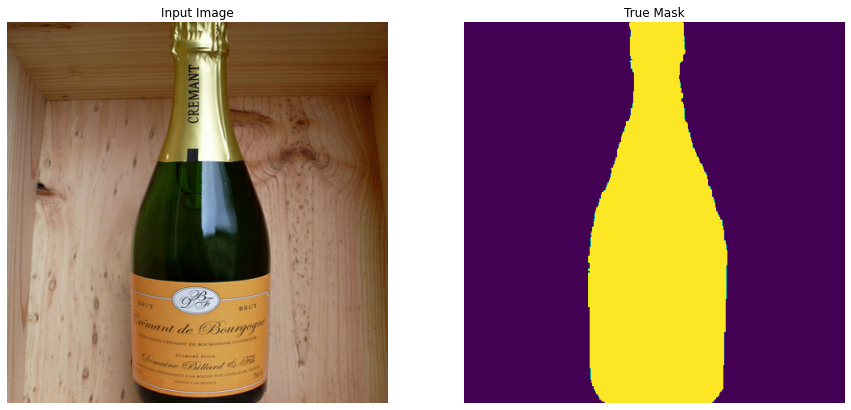

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in train_ds.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [0]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

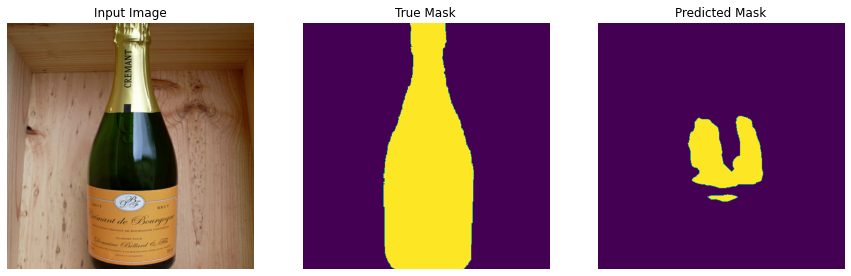


Sample Prediction after epoch 39

100/100 [==============================] - 525s 5s/step - mse: 48.6665 - accuracy: 0.7654 - loss: 0.9252 - val_mse: 59.0175 - val_accuracy: 0.7464 - val_loss: 1.0242
Epoch 40/100
 20/100 [=====>........................] - ETA: 5:49 - mse: 49.6238 - accuracy: 0.7940 - loss: 0.8365

In [0]:
EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 1800//BATCH_SIZE//VAL_SUBSPLITS

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
  model = pspnet((IMG_DIM, IMG_DIM, 3), OUTPUT_CHANNELS)
  model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', 'mse'])

  model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=(800 // BATCH_SIZE),
                          validation_steps=VALIDATION_STEPS,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback()])

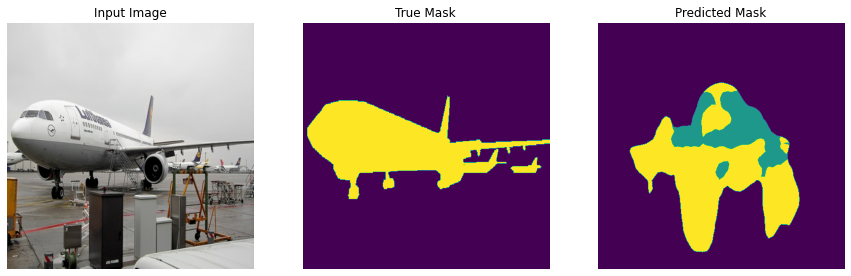

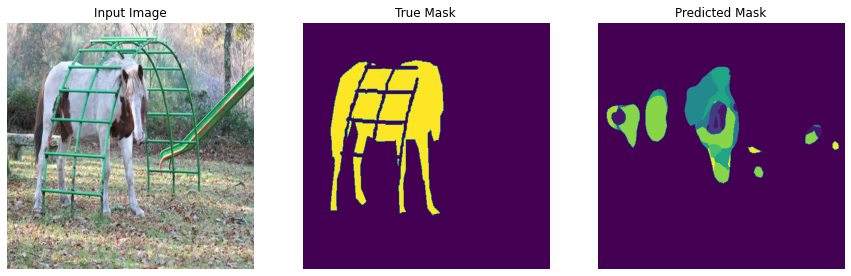

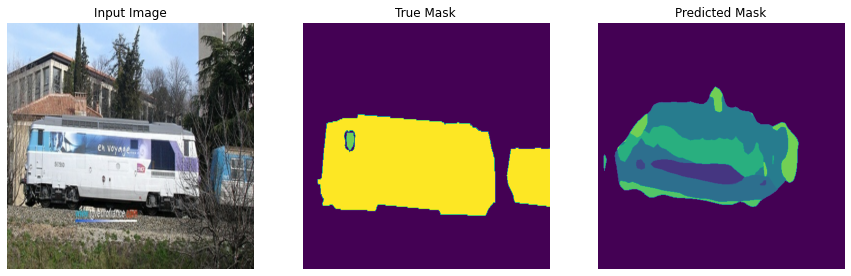

In [8]:
show_predictions(valid_dataset, 3)